In [14]:
%reload_ext autoreload
%autoreload 2

## import

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from numpy.linalg.linalg import svd
warnings.filterwarnings('ignore')
import pickle
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
torch.manual_seed(42)
from numpy import pi, std
from InverseFuncs import *
from monkey_functions import *
from pathlib import Path
from plot_ult import *
from stable_baselines3 import TD3
import pandas as pd
import seaborn as sns
torch.manual_seed(42)

In [16]:
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
datafolder=config['Datafolder']['data']
datapath=Path(datafolder)

## converge trend

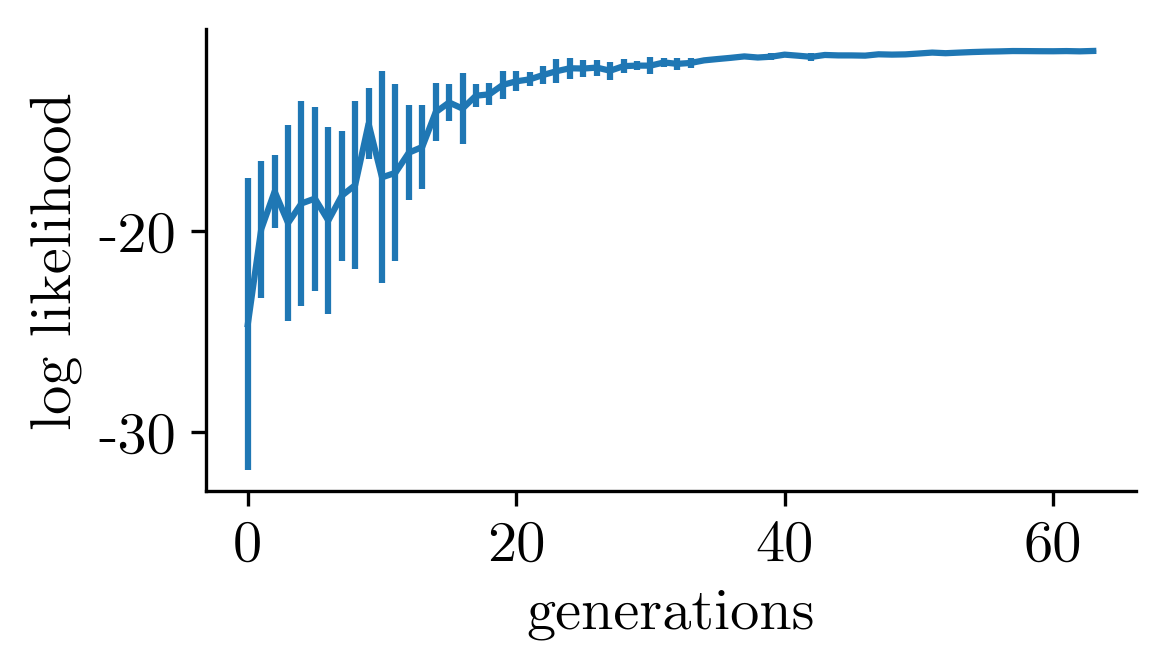

In [17]:
# likelihood converge trend ----------------------------

with open(datapath/'victor_pert/cmafull_victor_pert_ds', 'rb') as f:
    log = pickle.load(f)
optimizer=log[-1][0]
res=[l[2] for l in log]
loglls=[]
for r in res:
    genloglls=[]
    for point in r:
        genloglls.append(point[1])
    loglls.append(genloglls)
# gen=[[i]*optimizer.population_size for i in range(optimizer.generation)]
gen=np.array(range(optimizer.generation))
loglls=np.array(loglls)
logllmu=np.mean(loglls,axis=1)
logllstd=np.std(loglls,axis=1)
# confrange=np.array([percentile_err1d(eachlogll,percentile=90).tolist() for eachlogll in loglls]).T
# plt.errorbar(gen,logllmu,confrange)

with initiate_plot(4,2,300) as f:
    ax=f.add_subplot(111)
    quickspine(ax)
    ax.errorbar(gen,-logllmu,logllstd)
    # loglls=torch.tensor(loglls).flatten()
    ax.set_xlabel('generations')
    ax.set_ylabel('log likelihood')
    # quicksave('logll vs gen')



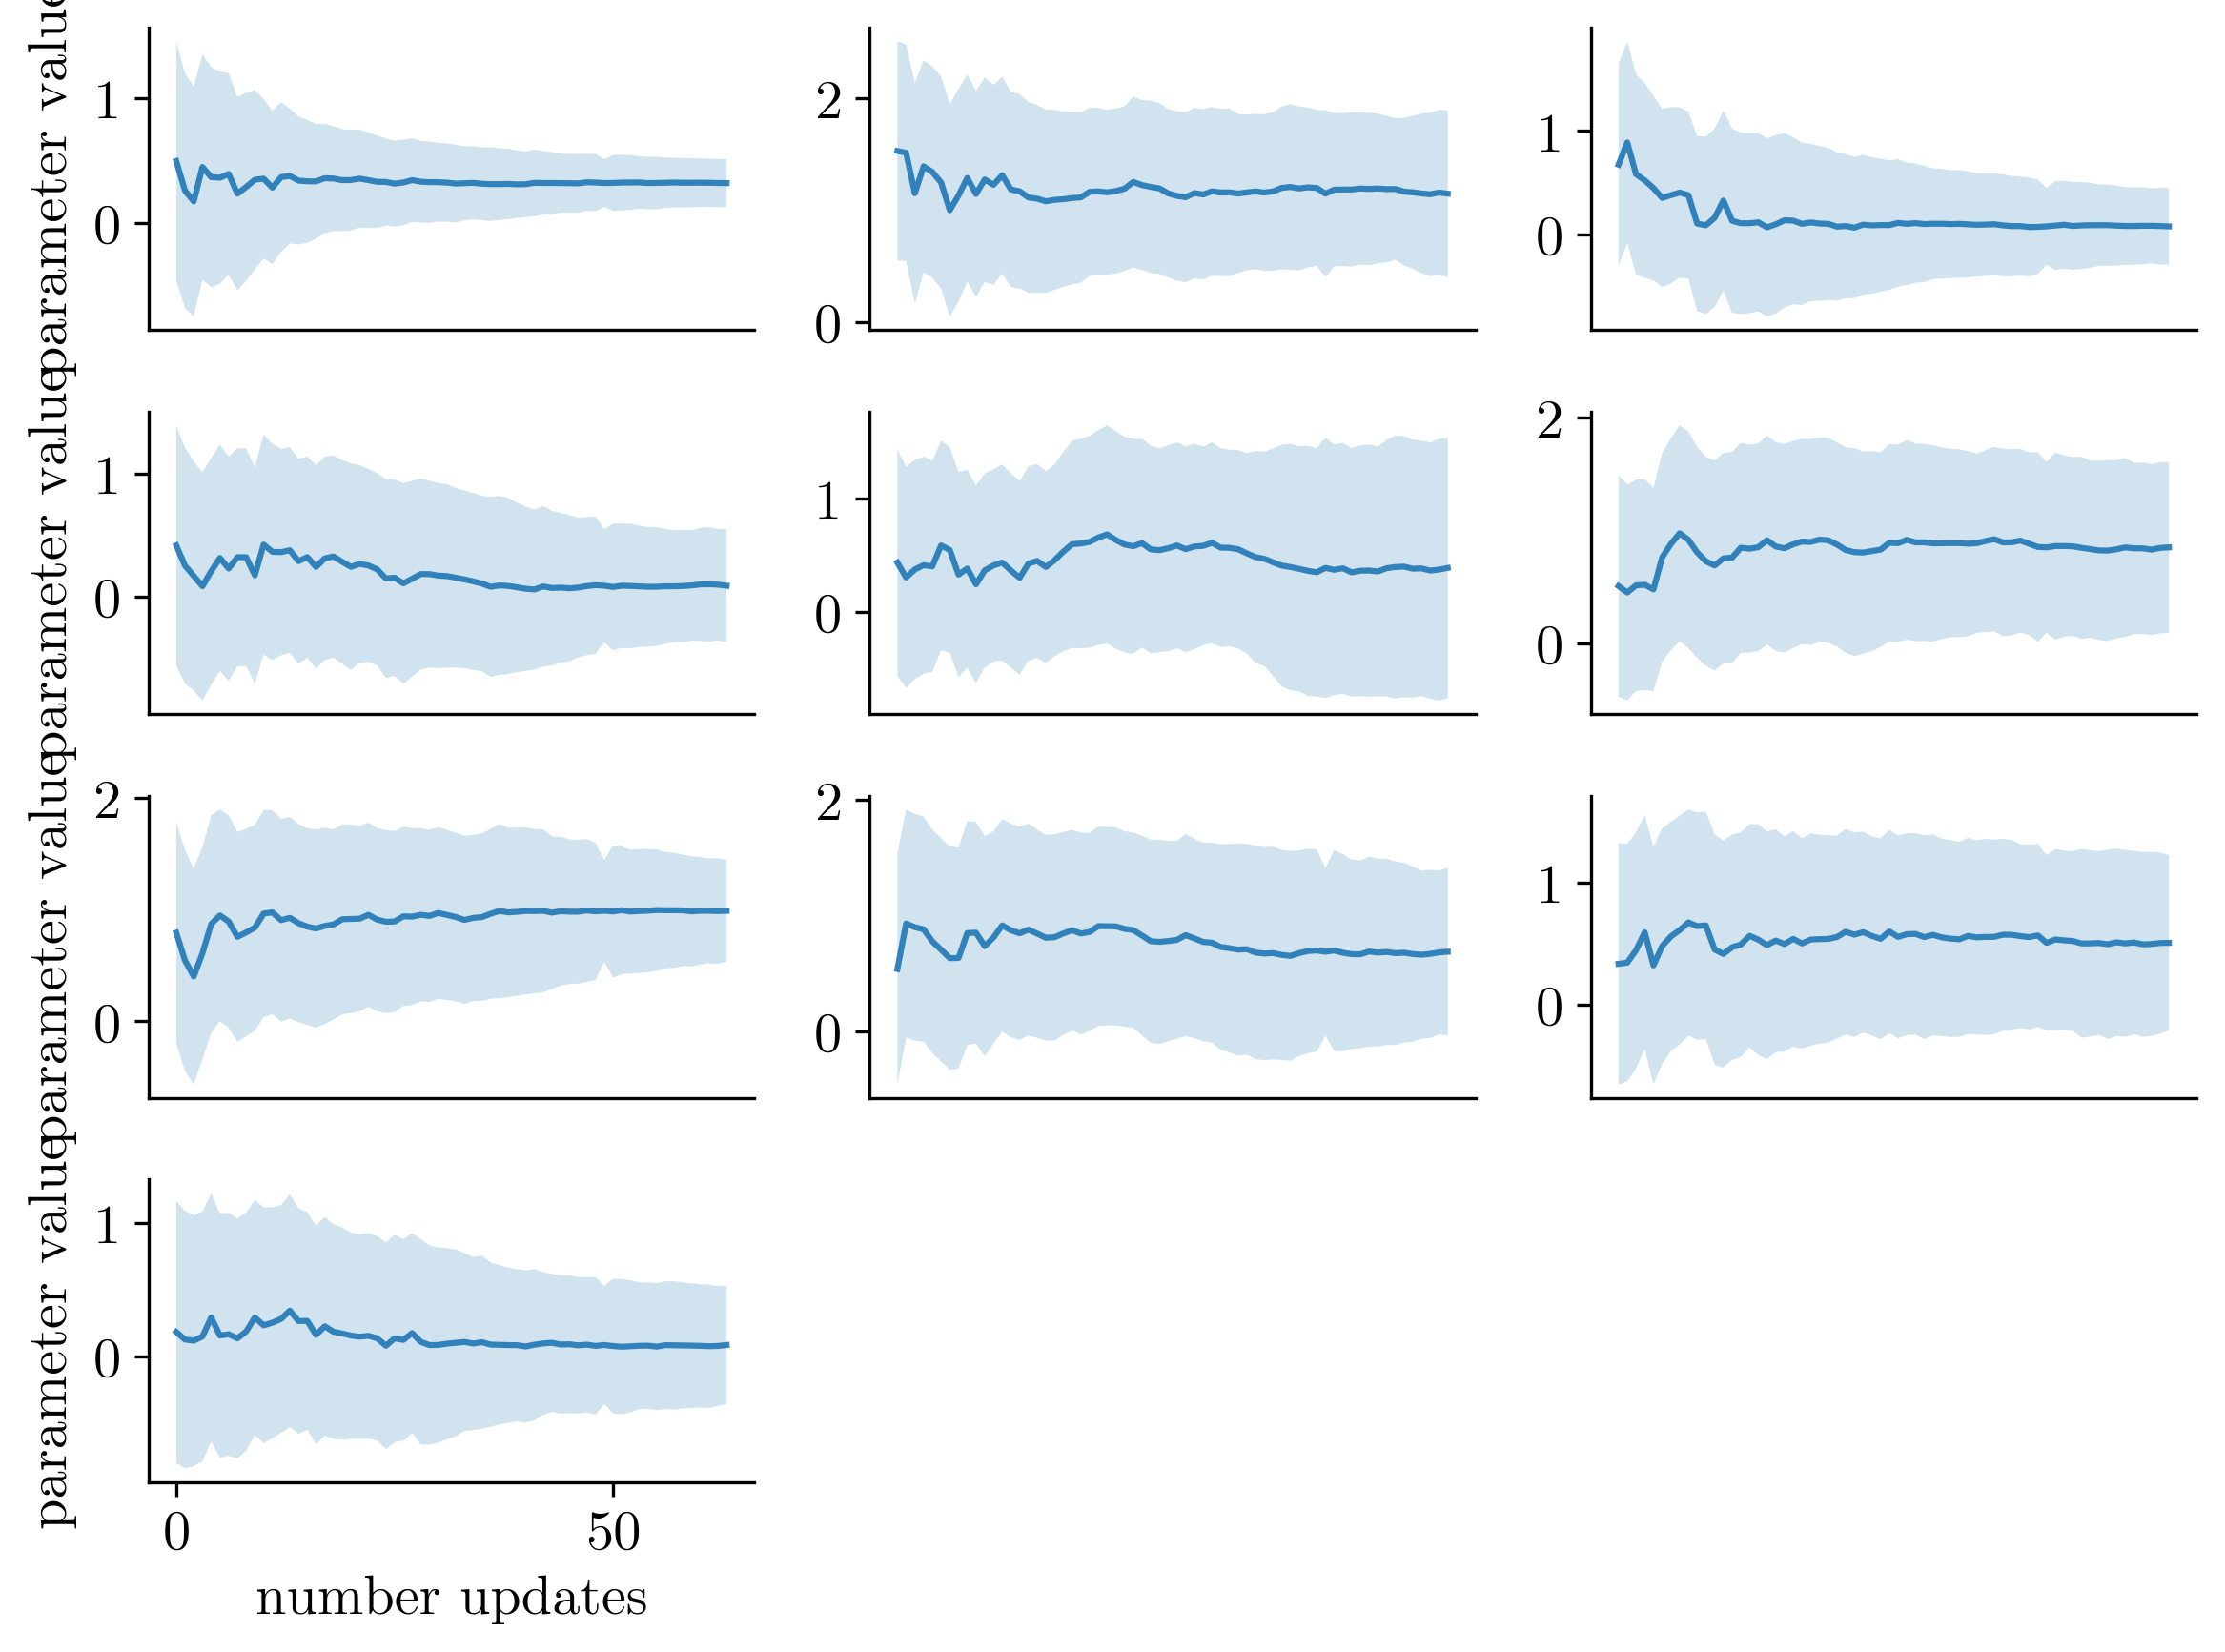

In [18]:
# theta trend
means=[l[0]._mean for l in log]
covs=[l[0]._C for l in log]
stds=[np.diag(cov)**0.5 for cov in covs]
means=np.array(means)
stds=np.array(stds)
means=np.delete(means,6,axis=1)
stds=np.delete(stds,6,axis=1)
nparam=means.shape[1]
nbyn=int(nparam**0.5) if nparam**0.5//1==0 else int(nparam**0.5//1+1)
nrow=nbyn
ncol=int(np.ceil(nparam//int(nparam**0.5)))
fig,axs=plt.subplots(nrow, ncol,figsize=(2*nrow,2*ncol) ,dpi=300)
for i in range(nrow):
    for j in range(ncol):
        ax=axs[i,j]
        quickspine(ax)
        cur=i*ncol+j
        if cur>=nparam:
            ax.remove()
            continue
        ax.plot(means[:,cur],alpha=0.9)
        ax.fill_between([j for j in range(stds.shape[0])],y1=means[:,cur]+stds[:,cur],y2=means[:,cur]-stds[:,cur],alpha=0.2)
        if i!=nrow-1:
            ax.set_xticks([])
            ax.set_xticklabels([])
        else:
            ax.set_xticks([0,50])
            ax.set_xlabel('number updates')
        if j==0:
            ax.set_ylabel('parameter value')
    plt.tight_layout()
    # quicksave('theta trend for sup')



In [20]:

# % likelihood surface in pca theta trajectory (many trajectories) ----------------------------
# load inverse log
# calculate pc
# plot



# % bar plot, error bar showing parameters ----------------------------
# load inverse logs
# plot


# % eigen vectors, ----------------------------
# load inverse log
# calculate eig
# plot



In [ ]:

# eig cov heatmap -----------------------------------------------------
theta,cov,err=process_inv(datapath/"bruno_pert/cmafull_packed_bruno_pert")
# theta,cov,err=process_inv("Z:/bruno_normal/preallpacked")
ev, evector=torch.linalg.eig(torch.tensor(cov),eigenvectors=True)
ev=ev[:,0]
ev,esortinds=ev.sort(descending=False)
evector=evector[:,esortinds]
inds=[1, 3, 5, 7, 0, 2, 4,6, 8, 9]
with initiate_plot(5,5,300) as fig:
    ax=fig.add_subplot(1,1,1)
    img=ax.imshow(evector[inds],cmap=plt.get_cmap('bwr'),
            vmin=-torch.max(evector),vmax=torch.max(evector),origin='upper')
    c=plt.colorbar(img,fraction=0.046, pad=0.04)
    c.set_label('parameter weight')
    ax.set_title('eigen vectors of covariance matrix')
    x_pos = np.arange(len(theta_names))
    plt.yticks(x_pos, [theta_names[i] for i in inds],ha='right')
    ax.set_xticks([])
    # quicksave('eigvector heatmap bruno pert')

with initiate_plot(5,1,300) as fig:
    ax=fig.add_subplot(1,1,1)
    x_pos = np.arange(len(theta_names))
    # Create bars and choose color
    ax.bar(x_pos, torch.sqrt(ev), color = color_settings['hidden'])
    for i, v in enumerate(torch.sqrt(ev)):
        number='{0:.2f}'.format(v.item())[1:] if v.item()<1 else '{0:.2f}'.format(v.item())
        ax.text( i-0.4,v+0.2 , number, color=color_settings['hidden'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel('sqrt of eigen values')
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    # quicksave('eigvalue bruno pert')


In [19]:

# % covariance  ----------------------------
# load inverse log
theta,cov,err=process_inv(datapath/"bruno_pert/cmafull_packed_bruno_pert")
# plot
with initiate_plot(4,4,300) as fig:
    ax=fig.add_subplot(1,1,1)
    cov=torch.tensor(cov)
    im=plt.imshow(cov[inds].t()[inds].t(),cmap=plt.get_cmap('bwr'),vmin=-torch.max(cov),vmax=torch.max(cov))
    ax.set_title('covariance matrix', fontsize=20)
    c=plt.colorbar(im,fraction=0.046, pad=0.04)
    c.set_label('covariance')
    x_pos = np.arange(len(theta_names))
    plt.yticks(x_pos, [theta_names[i] for i in inds],ha='right')
    plt.xticks(x_pos, [theta_names[i] for i in inds],rotation=45,ha='right')
    


/Users/yc/Documents/lab_data/bruno_pert/cmafull_packed_bruno_pert
using ind:  -1 final logll :  12.696784836905342


ValueError: need at least one array to concatenate

In [ ]:

# % correlation ----------------------------
# load inverse log
theta,cov,err=process_inv("Z:/bruno_pert/cmafull_packed_bruno_pert")
correlation=correlation_from_covariance(cov)
inds=[1, 3, 5, 7, 0, 2, 4, 6, 8, 9]

correlation=correlation-torch.diag(torch.diag(correlation))+torch.diag(torch.diag(cov))
correlationsorted=correlation[inds].T[inds].T
for i in range(10):
    for j in range(10):
        if i<j:
            correlationsorted[i,j]=0
seplines=[]
for i in range(10):
    seplines.append([[i-0.5,i+0.5],[i+0.5,i+0.5]])
    seplines.append([[i-0.5,i-0.5],[i-0.5,i+0.5]])

# correlation as step
with initiate_plot(4,4,300) as fig:
    ax=fig.add_subplot(1,1,1)
    quickspine(ax)
    for sline in seplines:
        ax.plot(sline[0],sline[1],'k')
    im=ax.imshow(correlationsorted,cmap=plt.get_cmap('bwr'),
        vmin=-1,vmax=1)
    ax.set_title('correlation matrix', fontsize=16)
    c=plt.colorbar(im,fraction=0.046, pad=0.04,ticks=[-1, 0, 1])
    c.set_label('correlation')
    x_pos = np.arange(len(theta_names))
    plt.yticks(x_pos, [theta_names[i] for i in inds],ha='right')
    plt.xticks(x_pos, [theta_names[i] for i in inds],rotation=45,ha='right')
    # quicksave('correlation matrix bruno pert with var')

# full correlation
theta,cov,err=process_inv("Z:/bruno_normal/preallpacked")
corr=correlation_from_covariance(cov)
inds=[1, 3, 5, 7, 0, 2, 4,6, 8, 9]
b=torch.diag(torch.tensor(cov),0)
S=torch.diag(torch.sqrt(b))
Sinv=torch.inverse(S)
correlation=Sinv@cov@Sinv
with initiate_plot(4,4,300) as fig:
    ax=fig.add_subplot(1,1,1)
    im=ax.imshow(correlation[inds].t()[inds].t(),cmap=plt.get_cmap('bwr'),
        vmin=-torch.max(correlation),vmax=torch.max(correlation))
    ax.set_title('correlation matrix', fontsize=16)
    c=plt.colorbar(im,fraction=0.046, pad=0.04,ticks=[-1, 0, 1])
    c.set_label('correlation')
    x_pos = np.arange(len(theta_names))
    plt.yticks(x_pos, [theta_names[i] for i in inds],ha='right')
    plt.xticks(x_pos, [theta_names[i] for i in inds],rotation=45,ha='right')
    # quicksave('correlation matrix bruno normal')

# % theta varing by first eigen vector (the mattered most direction) ----------------------------





# % infered internal model has similar behaviors to monkeys ----------------------------






# % TODO. same trials overhead, Acceleration/color gradient velocity path, path simlar and stop similar ----------------------------




# % same trials control curves ----------------------------




# % example monkey error trial explained. overhead belief and mk path ----------------------------
